<a href="https://colab.research.google.com/github/sboomi/chatbot-api/blob/main/ChatbotModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build a chatbot (Torch)

A chatbot is very useful for companies because it can interact with a customer and provide useful information on the service without getting past the main page in some of the cases.

A chatbot works by parsing the contents from a message the user sent, analyze it and return the appropriate response. 

A chatbot can be coded with DL using a **recurrent neural network (RNN)**. It needs an `intents.json` file for the bot to work.

An `intents.json` file is written like this

```json
{"intents": [
        {"tag": "greeting",
         "patterns": ["Hi there", "How are you", "Is anyone there?", "Hello", "Good day"],
         "responses": ["Hello, thanks for asking", "Good to see you again", "Hi there, how can I help?"],
         "context": [""]
        },
        {"tag": "goodbye",
         "patterns": ["Bye", "See you later", "Goodbye", "Nice chatting to you, bye", "Till next time"],
         "responses": ["See you!", "Have a nice day", "Bye! Come back again soon."],
         "context": [""]
        },
        //...
        ]
}
```

It takes a list of objects tagged by topic, conaining a list of patterns to detect and responses to answer with.

In [ ]:
import torch
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import json
import pickle
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


First let's import the `intents.json` file and open it.

In [ ]:
path_data = Path('drive/MyDrive/data/chatbot/intents.json')
path_data

PosixPath('drive/MyDrive/data/chatbot/intents.json')

In [ ]:
with open(path_data, 'r') as f:
  intents = json.load(f)

for intent in intents['intents']:
  print("Category:", intent['tag'])
  print("Data:\n", intent['patterns'])
  print("Possible responses:\n", intent['responses'])
  print("Context:\n", intent['context'], '\n')

Category: greeting
Data:
 ['Hi there', 'How are you', 'Is anyone there?', 'Hey', 'Hola', 'Hello', 'Good day']
Possible responses:
 ['Hello, thanks for asking', 'Good to see you again', 'Hi there, how can I help?']
Context:
 [''] 

Category: goodbye
Data:
 ['Bye', 'See you later', 'Goodbye', 'Nice chatting to you, bye', 'Till next time']
Possible responses:
 ['See you!', 'Have a nice day', 'Bye! Come back again soon.']
Context:
 [''] 

Category: thanks
Data:
 ['Thanks', 'Thank you', "That's helpful", 'Awesome, thanks', 'Thanks for helping me']
Possible responses:
 ['Happy to help!', 'Any time!', 'My pleasure']
Context:
 [''] 

Category: noanswer
Data:
 []
Possible responses:
 ["Sorry, can't understand you", 'Please give me more info', 'Not sure I understand']
Context:
 [''] 

Category: options
Data:
 ['How you could help me?', 'What you can do?', 'What help you provide?', 'How you can be helpful?', 'What support is offered']
Possible responses:
 ['I can guide you through Adverse drug re

Notice at some point some patterns are empty. There's also a fourth key called **context** that can link one context to another.

```
Category: pharmacy_search
Data:
 ['Find me a pharmacy', 'Find pharmacy', 'List of pharmacies nearby', 'Locate pharmacy', 'Search pharmacy']
Possible responses:
 ['Please provide pharmacy name']
Context:
 ['search_pharmacy_by_name'] 

Category: search_pharmacy_by_name
Data:
 []
Possible responses:
 ['Loading pharmacy details']
Context:
 [''] 
 ```

 The category `search_pharmacy_by_name` doesn't have any data to provide, hwoever, it is linked as a subtopic for `pharmacy_search`, that can be invoked when the bot is requesting a pharmacy name to the user.

## Preprocessing

At first we need to tokenize the possible messages the user can submit. Tokenization is a process in which each sentences is decomposed into a list of words.

Each sentence must be stored inside a corpus of documents, each tag being attached. Also, the classes, represented by the tags, must be stored somewhere too.

It's organized so we can create a **bag of word** matrix much later.

In [ ]:
# List of all the words present in the patterns
words = []
# List of all tags in the dataset
classes = set()
# Corpus representing a token + a tag
documents = []

for intent in intents['intents']:
  for pattern in intent['patterns']:
    word = nltk.word_tokenize(pattern)
    words.extend(word)
    documents.append((word, intent['tag']))
    classes.add(intent['tag'])

for word, tag in documents:
  print("Topic:", tag)
  print("Tokens:\n", word)

Topic: greeting
Tokens:
 ['Hi', 'there']
Topic: greeting
Tokens:
 ['How', 'are', 'you']
Topic: greeting
Tokens:
 ['Is', 'anyone', 'there', '?']
Topic: greeting
Tokens:
 ['Hey']
Topic: greeting
Tokens:
 ['Hola']
Topic: greeting
Tokens:
 ['Hello']
Topic: greeting
Tokens:
 ['Good', 'day']
Topic: goodbye
Tokens:
 ['Bye']
Topic: goodbye
Tokens:
 ['See', 'you', 'later']
Topic: goodbye
Tokens:
 ['Goodbye']
Topic: goodbye
Tokens:
 ['Nice', 'chatting', 'to', 'you', ',', 'bye']
Topic: goodbye
Tokens:
 ['Till', 'next', 'time']
Topic: thanks
Tokens:
 ['Thanks']
Topic: thanks
Tokens:
 ['Thank', 'you']
Topic: thanks
Tokens:
 ['That', "'s", 'helpful']
Topic: thanks
Tokens:
 ['Awesome', ',', 'thanks']
Topic: thanks
Tokens:
 ['Thanks', 'for', 'helping', 'me']
Topic: options
Tokens:
 ['How', 'you', 'could', 'help', 'me', '?']
Topic: options
Tokens:
 ['What', 'you', 'can', 'do', '?']
Topic: options
Tokens:
 ['What', 'help', 'you', 'provide', '?']
Topic: options
Tokens:
 ['How', 'you', 'can', 'be', 'helpf

The next step is **lemmatization**. Each word is converted into its lemma form to reduce the number of total words. As such, the number of words is reduced.

In example, let's consider the following words: *"sing", "singing", "sing", "sang", "sung"*. Lemmatizing these words means they can all be connected to one single word: *"sing"*. The verbal declinations are removed and so are the singular and plural forms. In other languages, it can extend to other tenses or gendered forms.

For that, we'll use NLTK's [wordnet](http://wordnet.princeton.edu/) lemmatizer, a lexical database of English. While we retrieve the lemma, we'll make sure they're in lower case and don't contain any punctuation.

In [ ]:
# Init lemmatizer
lemmatizer = WordNetLemmatizer()

# Punctuation
ignore_letters = ['!', '?', ',', '.']

# Lemmatize, remove duplicates and sort
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_letters]
words = sorted(list(set(words)))

# Sort classes
classes = sorted(list(classes))

print(f"N° of documents: {len(documents)}")
print(f"N° of classes: {len(classes)}\n{classes}")
print(f"N° of words: {len(words)}\nList of unique words:\n{words}")

N° of documents: 47
N° of classes: 9
['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
N° of words: 87
List of unique words:
["'s", 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want', 'what', 'which', 'with', 'you']


We can save the results in a pickle file and even use OOP to save the results.

In [ ]:
def load_intents(fp):
  with open(fp, 'r') as f:
    intents = json.load(f)
  return intents

class IntentLoader:
  def __init__(self, fp):
    self.intents = load_intents(fp)
    self.classes = []
    self.documents = []
    self.words = []
    self.ignore_letters = ['!', '?', ',', '.']
    self.lemmatizer = WordNetLemmatizer()
  def fit(self):
    for intent in self.intents['intents']:
      for pattern in intent['patterns']:
        word = nltk.word_tokenize(pattern)
        self.words.extend(word)
        self.documents.append((word, intent['tag']))
        self.classes.append(intent['tag'])

    # Lemmatize, remove duplicates and sort
    self.words = [self.lemmatizer.lemmatize(w.lower()) for w in self.words if w not in self.ignore_letters]
    self.words = sorted(list(set(self.words)))
    # Sort classes
    self.classes = sorted(list(set(self.classes)))
    print(f"Fit {len(self.documents)} documents for {len(self.classes)} classes (total words: {len(self.words)})")

  def describe(self):
    if not self.classes:
      print("No class found. Perform IntentLoader.fit() first.")
      return
    print(f"N° of documents: {len(self.documents)}")
    print(f"N° of classes: {len(self.classes)}\n{self.classes}")
    print(f"N° of words: {len(self.words)}\nList of unique words:\n{self.words}")  

  def __str__(self):
    return f"N° of categories: {len(self.intents['intents'])}"

il = IntentLoader(path_data)
il.fit()
il.describe()

with open(path_data.parent / 'intentloader.pkl','wb') as file:
  pickle.dump(il, file)

Fit 47 documents for 9 classes (total words: 87)
N° of documents: 47
N° of classes: 9
['adverse_drug', 'blood_pressure', 'blood_pressure_search', 'goodbye', 'greeting', 'hospital_search', 'options', 'pharmacy_search', 'thanks']
N° of words: 87
List of unique words:
["'s", 'a', 'adverse', 'all', 'anyone', 'are', 'awesome', 'be', 'behavior', 'blood', 'by', 'bye', 'can', 'causing', 'chatting', 'check', 'could', 'data', 'day', 'detail', 'do', 'dont', 'drug', 'entry', 'find', 'for', 'give', 'good', 'goodbye', 'have', 'hello', 'help', 'helpful', 'helping', 'hey', 'hi', 'history', 'hola', 'hospital', 'how', 'i', 'id', 'is', 'later', 'list', 'load', 'locate', 'log', 'looking', 'lookup', 'management', 'me', 'module', 'nearby', 'next', 'nice', 'of', 'offered', 'open', 'patient', 'pharmacy', 'pressure', 'provide', 'reaction', 'related', 'result', 'search', 'searching', 'see', 'show', 'suitable', 'support', 'task', 'thank', 'thanks', 'that', 'there', 'till', 'time', 'to', 'transfer', 'up', 'want',

In [ ]:
# If saved somewhere, load this cell
with open(path_data.parent / 'intentloader.pkl','rb') as file:
  il = pickle.load(file)

Now we'll prepare the training set. The training set will regroup the data and the target and has the same length than the number of documents.

* The data consists of a bag scrolling through every single unique word and checking if they are in the document or not (1 if they are, 0 otherwise).
* The target marks the index where the class (topic) is located.

In [ ]:
train_set = []
output_empty = [0] * len(il.classes)

for doc_words, tag in il.documents:
  bag = []

  # Preprocessing of the words to compare them to the list of words in the corpus
  word_patterns = [il.lemmatizer.lemmatize(word.lower()) for word in doc_words]

  # Go through all the words and signal if the document word is there or not
  for word in il.words:
    bag.append(1) if word in word_patterns else bag.append(0)

  # Marks the tag from the output
  output_row = output_empty[:]
  output_row[il.classes.index(tag)] = 1

  # First column is the bow data, second column is the class
  train_set.append([bag, output_row])


random.shuffle(train_set)
train_set = np.array(train_set, dtype=object)

train_x = list(train_set[:,0])
train_y = list(train_set[:,1])
print("Training data is created")
print(f"N° samples X: {len(train_x)}, n° samples y {len(train_y)}")

Training data is created
N° samples X: 47, n° samples y 47


## Create model

The model is a simple artificial neural network, composed of some regular dense layers, for classification. We'll use cross-entropy loss as a criterion and the SGD as the optimizer.

We will run the training over 200 epochs and maintain a batch size of 5.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

layers = [nn.Linear(len(train_x[0]), 128),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(64, len(train_y[0]))]

criterion = nn.CrossEntropyLoss()

model = nn.Sequential(*layers)
optim = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-6, momentum=0.9, nesterov=True)

print(model)

Current device: cpu
Sequential(
  (0): Linear(in_features=87, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=9, bias=True)
)


In [ ]:
# Prep the dataset
epochs=200
batch_size=5

train_ds = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
print(f"N° of documents in dataset: {len(train_ds)}")

train_dl = DataLoader(train_ds, batch_size=batch_size)
print(f"N° of batches {len(train_dl)} (batch size {train_dl.batch_size})")

N° of documents in dataset: 47
N° of batches 10 (batch size 5)


Current loss: 20.80
Current loss: 13.75
Current loss: 5.97
Current loss: 3.03
Current loss: 2.53
Current loss: 2.64
Current loss: 0.90
Current loss: 0.35
Current loss: 0.86
Current loss: 0.62
Current loss: 0.87
Current loss: 0.55
Current loss: 0.16
Current loss: 0.20
Current loss: 0.24
Current loss: 0.30
Current loss: 0.14
Current loss: 0.12
Current loss: 1.66
Current loss: 0.06



Text(0, 0.5, 'Loss')

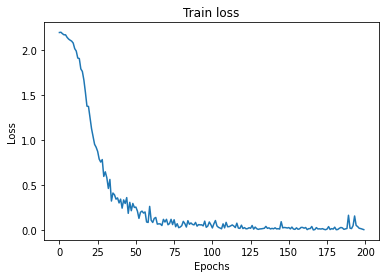

In [ ]:
# Training model

# Note for criterion
# output = torch.autograd.Variable(torch.randn(10, 120).float())
# target = torch.autograd.Variable(torch.FloatTensor(10).uniform_(0, 120).long())

model = model.to(device)
criterion = criterion.to(device)

model.zero_grad()
model.train()

loss_history = []
for epoch in trange(epochs):

  loss_batch = 0
  for bn, (data, label) in enumerate(train_dl):
    data, label = data.to(device), label.to(device)

    # Forward pass
    output = model(data)
    loss = criterion(output, label.argmax(dim=1))

    optim.zero_grad()
    loss.backward()
    optim.step()  

    # Register loss
    loss_batch += loss.detach().item()

  loss_history.append(loss_batch / len(train_dl))
  if (epoch+1)%10==0:
    print(f"Current loss: {loss_batch:.2f}")

torch.save(model.state_dict(), path_data.parent / 'chatbot_model')

plt.plot(np.array(loss_history))
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

## Test model

In [ ]:
# Load model
cpu_device = torch.device('cpu')
model = nn.Sequential(*layers)
model.load_state_dict(torch.load(path_data.parent / 'chatbot_model', map_location=cpu_device))
model.eval()

Sequential(
  (0): Linear(in_features=87, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=64, out_features=9, bias=True)
)

In [ ]:
class ChatBotApp:
  def __init__(self, intents, model):
    self.intents = intents
    self.model = model

  def clean_sentence(self, sentence):
    s_words = nltk.word_tokenize(sentence)
    s_words = [self.intents.lemmatizer.lemmatize(word.lower()) for word in s_words]
    return s_words

  def bow(self, sentence, verbose=False):
    s_words = self.clean_sentence(sentence)
    bag = [0]*len(self.intents.words)
    for s in s_words:
      for i, word in enumerate(self.intents.words):
            if word == s: 
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if verbose:
                    print (f"found in bag: {word}")
    return torch.Tensor(bag) 

  @torch.no_grad()
  def predict_class(self, sentence):
    # filter below  threshold predictions
    p = self.bow(sentence)
    output = self.model(p)
    sort_preds, sort_idx = output.sort(descending=True)
    sort_classes = [self.intents.classes[i] for i in sort_idx.tolist()]
    res_dict = {label:p for label, p in zip(sort_classes, sort_preds.tolist())}
    return res_dict, self.intents.classes[output.argmax().item()]

  def generate_response(self, sentence):
    response = "Sorry I didn't udnerstand your request."
    _, best_tag =self.predict_class(sentence)
    for intent in self.intents.intents['intents']:
      if best_tag==intent['tag']:
        response = random.choice(intent['responses'])
        break
    return response

  def chat(self):
    while True:
      message = input("Please enter your message: ")
      response = self.generate_response(message)
      print(response)



In [ ]:
cb =  ChatBotApp(il, model)

cb.chat()

Please enter your message: Hello!
Good to see you again
Please enter your message: What's your name?
Offering support for Adverse drug reaction, Blood pressure, Hospitals and Pharmacies
Please enter your message: blood pressure?
Navigating to Blood Pressure module
Please enter your message: I'm fine fanks
Hi there, how can I help?
Please enter your message: By
Good to see you again
Please enter your message: bye
See you!


KeyboardInterrupt: ignored